In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Bidirectional, Conv1D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from pyspark.sql import functions as sf
import joblib

In [5]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [6]:
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read JSON file into DataFrame
json_file_path = "/home/vannini/harpia/flight_data.json"
df = spark.read.json(json_file_path)


df_s = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)
# df_s.printSchema()
# Print the DataFrame
# df.show()

23/07/03 21:32:18 WARN Utils: Your hostname, shire resolves to a loopback address: 127.0.1.1; using 192.168.1.126 instead (on interface wlp3s0)
23/07/03 21:32:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/03 21:32:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/vannini/.local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [7]:
df_s.show()

+---+-------------------+-----+--------------------+--------------------+----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
| id|               Type|error|                roll|               pitch| yaw|           heading|            rollRate|           pitchRate|             yawRate|         groundSpeed|           climbRate|    altitudeRelative|       throttlePct|
+---+-------------------+-----+--------------------+--------------------+----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|  0|Takeoff and landing| true|  0.0160099285079197|-0.00726505465933...|null|461.20050024305567|-9.80036708636525...|-0.00552425785785...|-0.01129696558460...| 0.12141013458125746| -0.4419510988008492|-0.10362918471831066|               0.0|
|  0|Takeoff and landing| tr

In [8]:
df_s.groupBy('id').count().groupBy().avg().show()

+-------+-----------------+
|avg(id)|       avg(count)|
+-------+-----------------+
|  257.0|92.00388349514563|
+-------+-----------------+



In [9]:
def info(df):
  print(df.info(verbose=True))
  return None

In [10]:
def nulls_qtd(df):
  print(df.isna().sum())
  return None

In [11]:
def describe(df, perc, drop_list = None):
  if drop_list == None:
    df.select_dtypes(include='number').describe(percentiles = perc)
  else:
    df.select_dtypes(include='number').drop(drop_list, axis=1).describe(percentiles = perc)
  return None

In [12]:
df_s.show()

+---+-------------------+-----+--------------------+--------------------+----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
| id|               Type|error|                roll|               pitch| yaw|           heading|            rollRate|           pitchRate|             yawRate|         groundSpeed|           climbRate|    altitudeRelative|       throttlePct|
+---+-------------------+-----+--------------------+--------------------+----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|  0|Takeoff and landing| true|  0.0160099285079197|-0.00726505465933...|null|461.20050024305567|-9.80036708636525...|-0.00552425785785...|-0.01129696558460...| 0.12141013458125746| -0.4419510988008492|-0.10362918471831066|               0.0|
|  0|Takeoff and landing| tr

In [13]:
def shape(df):
  # DataFrame shape
  print(f'Rows: {df.shape[0]}\n   \nColumns: {df.shape[1]}')
  return None

In [14]:
def select_columns(df, columns_names_list):
  df_new = df[columns_names_list]
  return df_new

In [15]:
def split_train_test(X, y, strat, perc = 0.25):
  """
  X: x's variables
  y: target variable (system response)
  perc: test data percentage (decimal value; default = 0.2 = 20% of data)
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=strat)

  # Resets all DFs indexes
  X_train.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  y_train.reset_index(drop = True, inplace = True)
  y_test.reset_index(drop = True, inplace = True)

  return X_train, X_test, y_train, y_test

# 2- Exploratory Data Analysis (EDA)

In [16]:
df = df_s.toPandas()
df.head()

id                 Type  error      roll     pitch  yaw     heading  \
0   0  Takeoff and landing   True  0.016010 -0.007265  NaN  461.200500   
1   0  Takeoff and landing   True  0.016027 -0.005862  NaN  461.051960   
2   0  Takeoff and landing   True  0.015220 -0.004188  NaN  460.996826   
3   0  Takeoff and landing   True  0.014331 -0.005217  NaN  460.898682   
4   0  Takeoff and landing   True -0.115646 -0.202248  NaN  461.743322   

   rollRate  pitchRate   yawRate  groundSpeed  climbRate  altitudeRelative  \
0 -0.000980  -0.005524 -0.011297     0.121410  -0.441951         -0.103629   
1 -0.001250   0.000677 -0.003737     0.160009  -0.443906          0.004935   
2  0.000472   0.003879 -0.019766     0.128934  -0.406455         -0.004935   
3 -0.002041  -0.004281 -0.004010     0.065151  -0.339478         -0.009869   
4 -0.290028  -0.249074 -0.040604     0.269550   0.292084          0.078955   

   throttlePct  
0     0.000000  
1     0.838891  
2     1.924491  
3     2.664697  
4     3.602067

In [17]:
df[df['error']==False].describe()

id          roll         pitch           yaw       heading  \
count  33017.000000  33017.000000  33017.000000  33017.000000  33017.000000   
mean     207.405155      0.000806      0.002833      0.844894    115.250263   
std      165.402414      0.008437      0.009592      0.762674    129.866613   
min        6.000000     -0.020466     -0.023518     -0.061491      0.000000   
25%       66.000000     -0.005022     -0.004126      0.075876      0.080000   
50%      134.000000      0.000648      0.002261      1.568556     85.260002   
75%      370.000000      0.007013      0.009642      1.570579     92.820000   
max      514.000000      0.023513      0.027969      1.581190    359.989990   

           rollRate     pitchRate       yawRate   groundSpeed     climbRate  \
count  33017.000000  33017.000000  33017.000000  33017.000000  33017.000000   
mean       0.000154     -0.000066     -0.000037      0.037203     -0.111073   
std        0.001544      0.001591      0.001599      0.022983      0.082060   
min       -0.004801     -0.004413     -0.004161      0.000375     -0.234207   
25%       -0.000828     -0.001275     -0.001214      0.018749     -0.173954   
50%        0.000223     -0.000081     -0.000036      0.033824     -0.138986   
75%        0.001211      0.001067      0.000924      0.050225     -0.063068   
max        0.004769      0.005313      0.004973      0.128819      0.135915   

       altitudeRelative   throttlePct  
count      33017.000000  33017.000000  
mean          -0.528727      0.012212  
std            0.423008      0.036281  
min           -0.971000      0.000000  
25%           -0.817000      0.000000  
50%           -0.756000      0.000000  
75%            0.024000      0.000000  
max            0.361000      0.120000

In [18]:
df[df['error']==True].describe()

id          roll         pitch  yaw       heading  \
count  14365.000000  14365.000000  14365.000000  0.0  14365.000000   
mean     195.420814      0.005449      0.025506  NaN    735.734097   
std      164.287193      0.434786      0.457408  NaN    699.536821   
min        0.000000     -1.895378     -1.931535  NaN      0.000000   
25%       60.000000     -0.031026     -0.041849  NaN    416.440885   
50%      124.000000      0.001032     -0.000912  NaN    439.583728   
75%      356.000000      0.038860      0.040421  NaN   1775.580784   
max      500.000000      1.898162      1.912334  NaN   1776.495326   

           rollRate     pitchRate       yawRate   groundSpeed     climbRate  \
count  14365.000000  14365.000000  14365.000000  14365.000000  14365.000000   
mean      -0.000550      0.005557      0.001593      6.001710     -0.179220   
std        0.770115      0.794651      0.084414      7.555147      2.205264   
min       -2.660523     -2.954048     -0.675547      0.000929     -6.530260   
25%       -0.023051     -0.022239     -0.007898      0.156115     -0.324221   
50%       -0.000062      0.000535     -0.000100      0.739665     -0.002159   
75%        0.023651      0.024089      0.007864     12.177888      0.287359   
max        2.641717      2.840332      4.658103     24.298469     14.658489   

       altitudeRelative   throttlePct  
count      14365.000000  14365.000000  
mean          38.257504      3.387154  
std           36.822243      0.491505  
min           -6.266885      0.000000  
25%           14.393404      3.454232  
50%           29.682999      3.454312  
75%           49.421213      3.503660  
max          213.289180      4.391864

In [19]:
df.pipe(shape)

Rows: 47382
   
Columns: 14


In [20]:
df.pipe(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47382 entries, 0 to 47381
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                47382 non-null  int64  
 1   Type              47382 non-null  object 
 2   error             47382 non-null  bool   
 3   roll              47382 non-null  float64
 4   pitch             47382 non-null  float64
 5   yaw               33017 non-null  float64
 6   heading           47382 non-null  float64
 7   rollRate          47382 non-null  float64
 8   pitchRate         47382 non-null  float64
 9   yawRate           47382 non-null  float64
 10  groundSpeed       47382 non-null  float64
 11  climbRate         47382 non-null  float64
 12  altitudeRelative  47382 non-null  float64
 13  throttlePct       47382 non-null  float64
dtypes: bool(1), float64(11), int64(1), object(1)
memory usage: 4.7+ MB
None


In [21]:
df.pipe(nulls_qtd)

id                      0
Type                    0
error                   0
roll                    0
pitch                   0
yaw                 14365
heading                 0
rollRate                0
pitchRate               0
yawRate                 0
groundSpeed             0
climbRate               0
altitudeRelative        0
throttlePct             0
dtype: int64


In [22]:
df[df["yaw"].isnull()]["id"].nunique()

156

In [23]:
df["yaw"] = df["yaw"].fillna(0)

<AxesSubplot:>

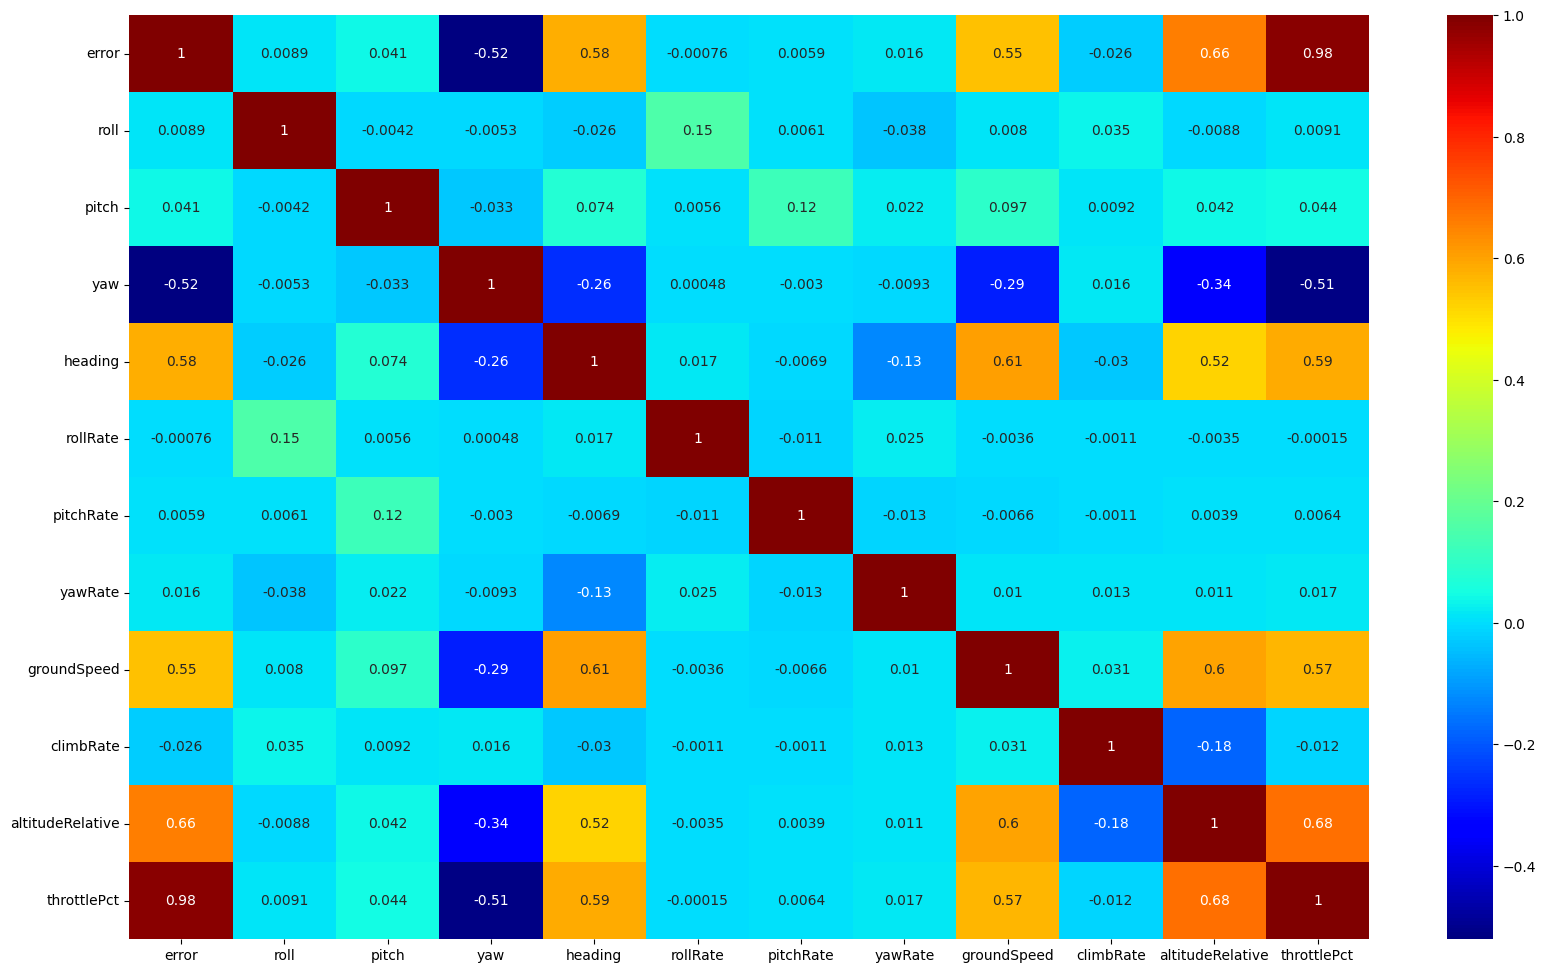

In [24]:
plt.figure(figsize=(20,12))
sns.heatmap(df.drop(['id'], axis=1).corr(), annot=True, cmap='jet')

# 3- Anomaly Detection (LSTM)

In [25]:
df_reduced = df.pipe(select_columns, ['roll', 'pitch', 'yaw', 'error'])
df_reduced.loc[:,'error'] = df_reduced['error'].astype(int)
df_reduced

/home/vannini/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


roll     pitch       yaw  error
0      0.016010 -0.007265  0.000000      1
1      0.016027 -0.005862  0.000000      1
2      0.015220 -0.004188  0.000000      1
3      0.014331 -0.005217  0.000000      1
4     -0.115646 -0.202248  0.000000      1
...         ...       ...       ...    ...
47377 -0.008456  0.008655  1.567685      0
47378 -0.008456  0.008655  1.567685      0
47379 -0.008456  0.008655  1.567685      0
47380 -0.008456  0.008655  1.567685      0
47381 -0.008456  0.008655  1.567685      0

[47382 rows x 4 columns]

In [26]:
#Preparing the data for LSTM model
data_n = df_reduced
data_n

roll     pitch       yaw  error
0      0.016010 -0.007265  0.000000      1
1      0.016027 -0.005862  0.000000      1
2      0.015220 -0.004188  0.000000      1
3      0.014331 -0.005217  0.000000      1
4     -0.115646 -0.202248  0.000000      1
...         ...       ...       ...    ...
47377 -0.008456  0.008655  1.567685      0
47378 -0.008456  0.008655  1.567685      0
47379 -0.008456  0.008655  1.567685      0
47380 -0.008456  0.008655  1.567685      0
47381 -0.008456  0.008655  1.567685      0

[47382 rows x 4 columns]

In [27]:
data_n.describe()

roll         pitch           yaw         error
count  47382.000000  47382.000000  47382.000000  47382.000000
mean       0.002214      0.009707      0.588744      0.303174
std        0.239506      0.252191      0.745741      0.459635
min       -1.895378     -1.931535     -0.061491      0.000000
25%       -0.006929     -0.006706      0.000000      0.000000
50%        0.000659      0.002103      0.081677      0.000000
75%        0.009251      0.012203      1.570055      1.000000
max        1.898162      1.912334      1.581190      1.000000

# LSTM Model - Pitch/Row/Yaw

In [28]:
x = data_n.drop(['error'],axis=1)
y = data_n.error

print(x.head())
print('\n\n')
print(y.head())

       roll     pitch  yaw
0  0.016010 -0.007265  0.0
1  0.016027 -0.005862  0.0
2  0.015220 -0.004188  0.0
3  0.014331 -0.005217  0.0
4 -0.115646 -0.202248  0.0



0    1
1    1
2    1
3    1
4    1
Name: error, dtype: int64


In [29]:
# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(35536, 3)
(35536,)
(11846, 3)
(11846,)


In [30]:
# Convert X_train and X_test to NumPy arrays
x_train = x_train.values
x_test = x_test.values

# Reshape your input data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Reshape y_train
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Reshape y_test
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

In [31]:
sz = x_train.shape[0] + x_test.shape[0]

print(f'Train relation: {(x_train.shape[0]/sz)*100}% of the data')
print(f'Test relation: {(x_test.shape[0]/sz)*100}% of the data')

Train relation: 74.99894474695031% of the data
Test relation: 25.00105525304968% of the data


In [48]:
# Define the function to create the LSTM model
def create_model(units=360, activation='linear', dropout_rate=0.2, optimizer='rmsprop'):
    model = Sequential()
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.add(Activation(activation))
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [49]:
# Create the KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'units': [200, 300, 400],
    'activation': ['linear', 'relu'],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['rmsprop', 'adam']
}


/home/vannini/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [50]:
# Perform grid search with cross-validation
cv = TimeSeriesSplit(n_splits=3)  # Adjust the number of splits as needed
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
start = time.time()
grid_result = grid_search.fit(x_train, y_train)
print('Grid search time : {}'.format(time.time() - start))

# Print the best parameters and score
print('Best parameters: {}'.format(grid_result.best_params_))
print('Best score: {}'.format(grid_result.best_score_))

Grid search time : 878.4201753139496
Best parameters: {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'adam', 'units': 400}
Best score: -0.11456396679083507


In [51]:
#Building the model
model = Sequential()


model.add(LSTM(400, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.012918949127197266


In [52]:
model.fit(x_train, y_train, batch_size=60, epochs=30, validation_split=0.1)

Epoch 1/30
534/534 [==============================] - 19s 30ms/step - loss: 0.1376 - val_loss: 0.1087
Epoch 2/30
534/534 [==============================] - 15s 29ms/step - loss: 0.1020 - val_loss: 0.0874
Epoch 3/30
534/534 [==============================] - 15s 29ms/step - loss: 0.0752 - val_loss: 0.0526
Epoch 4/30
534/534 [==============================] - 15s 29ms/step - loss: 0.0524 - val_loss: 0.0358
Epoch 5/30
534/534 [==============================] - 16s 30ms/step - loss: 0.0423 - val_loss: 0.0303
Epoch 6/30
534/534 [==============================] - 16s 30ms/step - loss: 0.0370 - val_loss: 0.0277
Epoch 7/30
534/534 [==============================] - 16s 30ms/step - loss: 0.0346 - val_loss: 0.0247
Epoch 8/30
534/534 [==============================] - 15s 28ms/step - loss: 0.0320 - val_loss: 0.0239
Epoch 9/30
534/534 [==============================] - 15s 29ms/step - loss: 0.0308 - val_loss: 0.0233
Epoch 10/30
534/534 [==============================] - 15s 29ms/step - loss: 0.029

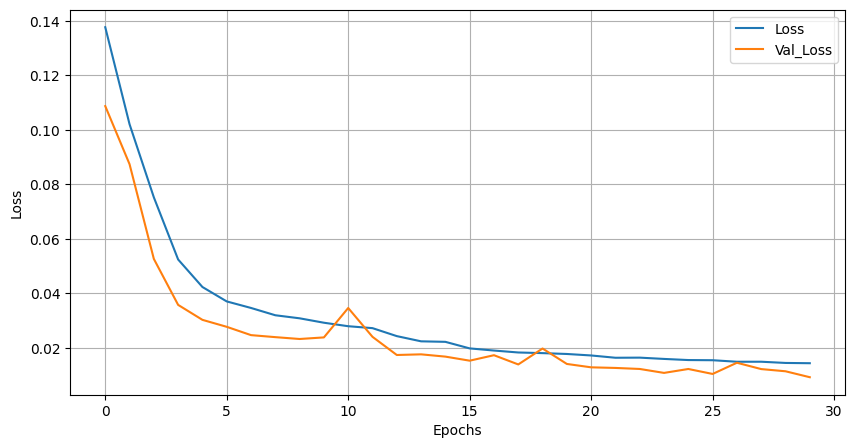

In [53]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [54]:
y_pred = model.predict(x_test)

371/371 [==============================] - 4s 8ms/step


In [55]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [56]:
threshold = 0
softmax_pred = np.where(y_pred[:, 0] >= threshold, 1, 0)

In [57]:
softmax_test = np.where(y_test[:, 0] >= threshold, 1, 0)

In [58]:
data_n.groupby('error').size().reset_index(name='count')

error  count
0      0  33017
1      1  14365

In [59]:
df.groupby('error').size().reset_index(name='count')

error  count
0  False  33017
1   True  14365

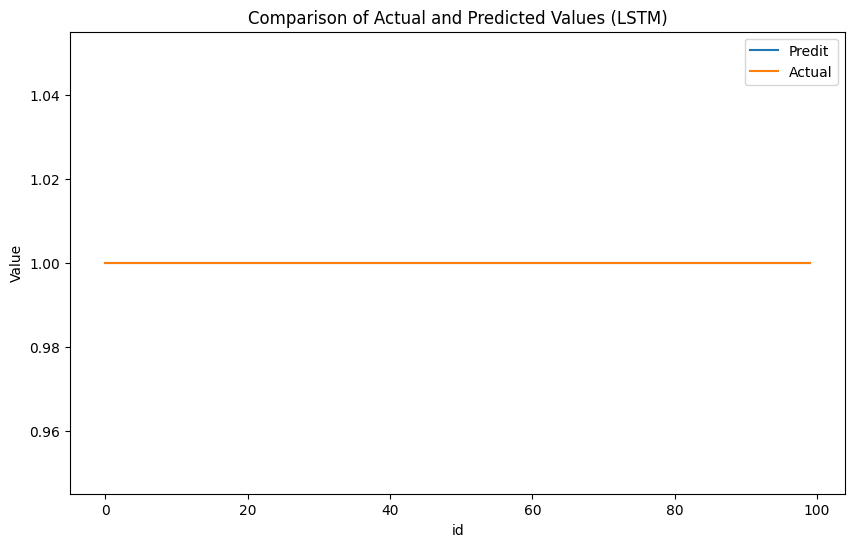

In [60]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(softmax_pred[500:600], label='Predit')
plt.plot(softmax_test[500:600], label='Actual')
# plt.plot(y_test[500:600], label='Actual')
# plt.plot(y_pred[500:600], label='Predicted')
plt.xlabel('id')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values (LSTM)')
plt.legend()
plt.show()

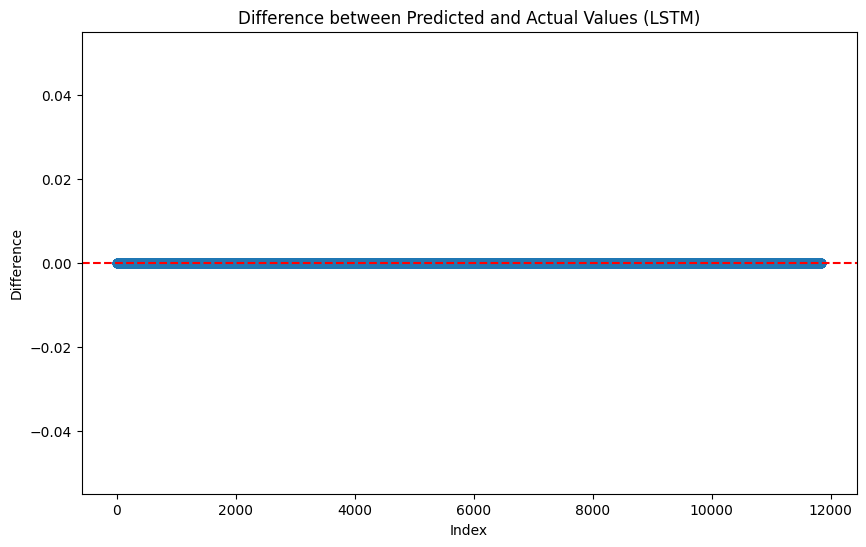

In [61]:
# Calculate the difference between predicted and actual values
difference = softmax_test - softmax_pred

# Plotting the difference as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(difference)), difference)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Difference between Predicted and Actual Values (LSTM)')
plt.show()

In [62]:
np.sum(np.abs(difference))/len(difference)*100

0.0

In [64]:
# ser'a q os erros estao muito suaves? ou muito absurdos?
## procurar base na internet com erro de pitch, roll e yaw

In [44]:
len(difference)

11846

In [66]:
df.groupby('error').count()

id   Type   roll  pitch    yaw  heading  rollRate  pitchRate  \
error                                                                    
False  33017  33017  33017  33017  33017    33017     33017      33017   
True   14365  14365  14365  14365  14365    14365     14365      14365   

       yawRate  groundSpeed  climbRate  altitudeRelative  throttlePct  
error                                                                  
False    33017        33017      33017             33017        33017  
True     14365        14365      14365             14365        14365

> Exporting Model

In [63]:
filename = "LSTM_PYR_NS.joblib"
joblib.dump(model, filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......dense
.........vars
............0
............1
......dropout
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-07-03 22:28:33         2039
metadata.json                                  2023-07-03 22:28:33           64
variables.h5                                   2023-07-03 22:28:33      7746584


['LSTM_PYR_NS.joblib']

In [64]:
loaded_LSTM = joblib.load(filename)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-07-03 22:28:32         2039
metadata.json                                  2023-07-03 22:28:32           64
variables.h5                                   2023-07-03 22:28:32      7746584
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......dense
.........vars
............0
............1
......dropout
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


In [81]:
data_n.drop(['error'],axis=1).values

array([[ 0.05760411, -0.06729817, -0.78948365],
       [ 0.05767553, -0.06173336, -0.78948365],
       [ 0.05430535, -0.05509496, -0.78948365],
       ...,
       [-0.04454806, -0.00416864,  1.31272319],
       [-0.04454806, -0.00416864,  1.31272319],
       [-0.04454806, -0.00416864,  1.31272319]])

In [65]:
test = [[-0.008122967793406688,-0.031792852469140896,-1.175610922771928]]
y_pred = loaded_LSTM.predict(test)

1/1 [==============================] - 1s 809ms/step


In [66]:
y_pred

array([[0.]], dtype=float32)

In [67]:
y_pred = loaded_LSTM.predict(data_n.drop(['error'],axis=1).values)

1481/1481 [==============================] - 14s 9ms/step


In [68]:
y_pred

array([[0.48506755],
       [0.44388354],
       [0.35480577],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [69]:
threshold = 0
softmax_pred = np.where(y_pred[:, 0] >= threshold, 1, 0)

In [70]:
softmax_test = np.where(data_n["error"].values >= threshold, 1, 0)

In [71]:
difference = softmax_test - softmax_pred

In [72]:
(np.sum(difference)/len(difference))*100

0.0